Predict job counts for various subcategories on www.mathjobs.org.

In [1]:
import json
import string
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import sklearn
#from mathjob_ovtime import find_trends
#from model import get_predictions

# The time period with which to do
# the analysis.
start = 2010
end = 2020

In [2]:
%%time
metadata_list  = []
with open("../data/raw/archive/arxiv-metadata-oai-snapshot.json", 'r') as f:
    for line in f: 
        metadata_list.append(json.loads(line))

Wall time: 3min 1s


In [7]:
# for testing 
metadata = pd.DataFrame(metadata_list)
print(metadata.shape)
metadata.head()

(1915641, 14)


id           submitter  \
0  0704.0001      Pavel Nadolsky   
1  0704.0002        Louis Theran   
2  0704.0003         Hongjun Pan   
3  0704.0004        David Callan   
4  0704.0005  Alberto Torchinsky   

                                             authors  \
0  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1                    Ileana Streinu and Louis Theran   
2                                        Hongjun Pan   
3                                       David Callan   
4           Wael Abu-Shammala and Alberto Torchinsky   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   
3  A determinant of Stirling cycle numbers counts...   
4  From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   

                                  comments  \
0  37 pages, 15 figures; published version   
1    To appear in Graphs and Combinatorics   
2                      23 pages, 3 figures   
3                                 11 pages   
4                                     None   

                                 journal-ref                         doi  \
0                   Phys.Rev.D76:013009,2007  10.1103/PhysRevD.76.013009   
1                                       None                        None   
2                                       None                        None   
3                                       None                        None   
4  Illinois J. Math. 52 (2008) no.2, 681-689                        None   

          report-no       categories  \
0  ANL-HEP-PR-07-12           hep-ph   
1              None    math.CO cs.CG   
2              None   physics.gen-ph   
3              None          math.CO   
4              None  math.CA math.FA   

                                             license  \
0                                               None   
1  http://arxiv.org/licenses/nonexclusive-distrib...   
2                                               None   
3                                               None   
4                                               None   

                                            abstract  \
0    A fully differential calculation in perturba...   
1    We describe a new algorithm, the $(k,\ell)$-...   
2    The evolution of Earth-Moon system is descri...   
3    We show that a determinant of Stirling cycle...   
4    In this paper we show how to compute the $\L...   

                                            versions update_date  \
0  [{'version': 'v1', 'created': 'Mon, 2 Apr 2007...  2008-11-26   
1  [{'version': 'v1', 'created': 'Sat, 31 Mar 200...  2008-12-13   
2  [{'version': 'v1', 'created': 'Sun, 1 Apr 2007...  2008-01-13   
3  [{'version': 'v1', 'created': 'Sat, 31 Mar 200...  2007-05-23   
4  [{'version': 'v1', 'created': 'Mon, 2 Apr 2007...  2013-10-15   

                                      authors_parsed  
0  [[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...  
1           [[Streinu, Ileana, ], [Theran, Louis, ]]  
2                                 [[Pan, Hongjun, ]]  
3                                [[Callan, David, ]]  
4  [[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]

In [8]:
metadata["update_date_mod"] = pd.to_datetime(metadata.update_date)
metadata["id"] = 1

In [9]:
# Sort the publications by year and only work with publications from 2009 to 2020
metadata = metadata.sort_values("update_date_mod")
metadata = metadata[(metadata.update_date_mod < "2021-01-01") & (metadata.update_date_mod > "2008-12-31")]

In [10]:
metadata.head(15)

id                        submitter  \
46445     1                         Zhao Ren   
86656     1                  Matthew Roberts   
94347     1                   Ralf Br\"uning   
8177      1                       JinLin Han   
1521839   1            Lister Staveley-Smith   
71587     1                Hartmut Schmieden   
17727     1  Khamidbi Beshtoev Mukhamedovich   
1727900   1  Khamidbi Beshtoev Mukhamedovich   
1521953   1                      Erik Muller   
88573     1                   Terence C. Tao   
62418     1                  Jorge P\'aramos   
84733     1               Robert J. Scherrer   
95811     1                Nguyen Quang Hung   
92055     1                Takashi Shimomura   
41073     1                   Simon Roessner   

                                                   authors  \
46445     Zhao Ren, Zhang Li-Chun, Li Huai-Fan, Wu Yue-Qin   
86656              Gary T. Horowitz and Matthew M. Roberts   
94347    Ralf Br\"uning, Denis A. St-Onge, Steve Patter...   
8177                                     Jinlin Han (NAOC)   
1521839  L. Staveley-Smith, S. Kim, M. R. Calabretta, R...   
71587    Frank Klein et al. (The CBELSA/TAPS Collaborat...   
17727                                      Kh. M. Beshtoev   
1727900                                    Kh. M. Beshtoev   
1521953  E. Muller, L. Staveley-Smith., W. Zealey, S. S...   
88573                                  Terence Tao, Van Vu   
62418                        O. Bertolami and J. P\'aramos   
84733                 Sourish Dutta and Robert J. Scherrer   
95811                       N. Quang Hung and N. Dinh Dang   
92055    Satoru Kaneko, Joe Sato, Takashi Shimomura, Os...   
41073    Simon Roessner, Thomas Hell, Claudia Ratti, Wo...   

                                                     title  \
46445    Entropy of Kerr-Newman black hole to all order...   
86656    Holographic Superconductors with Various Conde...   
94347    Glass transitions in 1, 2, 3, and 4 dimensiona...   
8177     Magnetic fields of our Galaxy on large and sma...   
1521839  A New Look at the Large-Scale HI Structure of ...   
71587    Beam asymmetry in near threshold omega photopr...   
17727    Majorana neutrino. Is double neutrinoless beta...   
1727900  Remarks to the Standard Theory of Neutrino Osc...   
1521953  High Resolution \hi observations of the Wester...   
88573    From the Littlewood-Offord problem to the Circ...   
62418    On the non-minimal gravitational coupling to m...   
84733                                 Hilltop Quintessence   
95811                       Pairing in hot rotating nuclei   
92055    Measuring Lepton Flavour Violation at LHC with...   
41073    The chiral and deconfinement crossover transit...   

                                                  comments  \
46445                                             12 pages   
86656       17 pages, 6 figures. v2: minor typos corrected   
94347                                 26 pages, 13 figures   
8177     9 pages. Invited Talk at IAU Symp.242, 'Astrop...   
1521839  Accepted by MNRAS, 19 pages, 13 figurs, 21 eps...   
71587                                   4 pages, 5 figures   
17727                                 12 pages, no figures   
1727900                               13 pages, no figures   
1521953  23 pages, 15 figures. Accepted for publication...   
88573    25 pages, 8 figures, to appear, Bull. Amer. Ma...   
62418                                             11 pages   
84733        7 pages, 9 figures, label on Fig. 4 corrected   
95811     30 pages and 9 figures. Accepted in Phys. Rev. C   
92055                        20 pages, 5 figures, 4 tables   
41073                       28 pages, 14 figures, 2 tables   

                                        journal-ref  \
46445            Int.J.Theor.Phys.47:3083-3090,2008   
86656                      Phys.Rev.D78:126008,2008   
94347    J. Phys.: Condens. Matter 21 (2009) 035117   
8177     IAU Symposium, Volume 242, p. 55

In [8]:
dg_df =  metadata[metadata.categories.str.contains("math.DG")]

In [10]:
dg_df.head(10)

id         submitter                        authors  \
1837750   1           Ping Xu        Kai Behrend and Ping Xu   
100638    1     Edward Witten                  Edward Witten   
1836660   1     David Brander                  David Brander   
101434    1    Thomas Russell                 Thomas Russell   
1841873   1  Benoit Kloeckner   Benoit Kloeckner (UMPA-ENSL)   
1838761   1  Fernando Dobarro  Fernando Dobarro, Bulent Unal   
63156     1     David Brander                  David Brander   
1829627   1  Benoit Kloeckner   Benoit Kloeckner (UMPA-ENSL)   
1829632   1  Benoit Kloeckner   Benoit Kloeckner (UMPA-ENSL)   
101603    1    Nitta Yasufumi                 Yasufumi Nitta   

                                                     title  \
1837750                   Differentiable Stacks and Gerbes   
100638                         The Problem Of Gauge Theory   
1836660  $k$-symmetric AKS systems and flat immersions ...   
101434   Additive Separability, Optimization, and Trivi...   
1841873  Sur les remplissages holomorphes \'{e}quivariants   
1838761     Hessian Tensor and Standard Static Space-times   
63156    Loop Group Decompositions in Almost Split Real...   
1829627  On differentiable compactifications of the hyp...   
1829632  On differentiable compactifications of the hyp...   
101603     Convexity properties of generalized moment maps   

                                                  comments  \
1837750  48 pages, minor revision, examples added, refe...   
100638                                                None   
1836660          21 pages. Minor typographical corrections   
101434                                                None   
1841873                                           19 pages   
1838761                12 pages, changed title and content   
63156                                             12 Pages   
1829627                                               18 p   
1829632                                               11 p   
101603   25pages, to appear in J. Math. Soc. Japan. In ...   

                                               journal-ref  \
1837750                                               None   
100638                                                None   
1836660         J. London Math. Soc. (2) 77 (2008) 299-319   
101434                                                None   
1841873  Annales de l'Institut Fourier 57, 6 (2007) 204...   
1838761  Advances in Lorentzian Geometry - M. Plaue and...   
63156                   J. Geom. Phys. 58 (2008) 1792-1800   
1829627             Geometriae Dedicata 125 (2007) 253-270   
1829632         Transformation Groups 11, 2 (2006) 185-194   
101603                                                None   

                                    doi report-no  \
1837750                            None      None   
100638                             None      None   
1836660             10.1112/jlms/jdm109      None   
101434                             None      None   
1841873                            None      None   
1838761                            None      None   
63156    10.1016/j.geomphys.2008.09.003      None   
1829627                            None      None   
1829632                            None      None   
101603                             None      None   

                            categories  \
1837750        math.DG math-ph math.MP   
100638          math.DG hep-th math.QA   
1836660                math.DG math.DS   
101434                 math.DG math.SG   
1841873                math.DG math.CV   
1838761  math.DG gr-qc math-ph math.MP   
63156          math.DG math-ph math.MP   
1829627                math.MG math.DG   
1829632                math.MG math.DG   
101603                 math.DG math.SG   

                                                   license  \
1837750  http://arxiv.org/licenses/nonexclusive-distrib...   
100638   http://arxiv.org/licenses/nonexclusive-distrib...   
1836660               

In [19]:
dg_df[:25].abstract.iloc[21]

'  We present two classical conjectures concerning the characterization of\nmanifolds: the Bing Borsuk Conjecture asserts that every $n$-dimensional\nhomogeneous ANR is a topological $n$-manifold, whereas the Busemann Conjecture\nasserts that every $n$-dimensional $G$-space is a topological $n$-manifold. The\nkey object in both cases are so-called {\\it generalized manifolds}, i.e. ENR\nhomology manifolds. We look at the history, from the early beginnings to the\npresent day. We also list several open problems and related conjectures.\n'

## Plot predictions for number theory

Text(0.5, 1.0, 'Number theory')

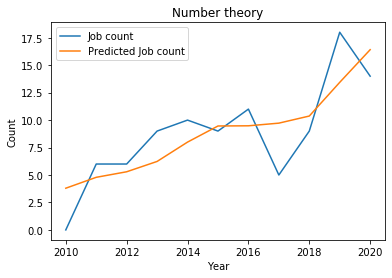

In [15]:
jobs = get_key_word_counts(r"(?i)number theory", start=start, end=end)
X = metadata[metadata.categories.str.contains("math.NT")].resample("Y", on="update_date_mod").sum()[1:]
y = jobs

predicted_data = get_predictions(X,y)

plt.plot(list(range(start, end+1)),y, label='Job count')
plt.plot(list(range(start, end+1)), predicted_data[1].reshape(-1,1), label='Predicted Job count')
plt.legend(loc="upper left")
plt.ylabel('Count')
plt.xlabel('Year')
plt.title("Number theory")

## Plot predictions for differential geometry

Text(0.5, 1.0, 'Differential geometry')

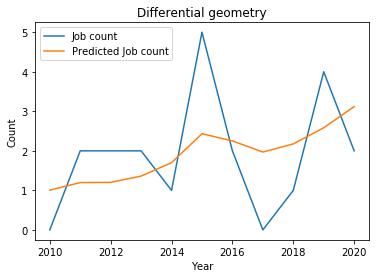

In [16]:
jobs = get_key_word_counts(r"(?i)differential geometry", start=start, end=end)
X = metadata[metadata.categories.str.contains("math.DG")].resample("Y", on="update_date_mod").sum()[1:]
y = jobs

predicted_data = get_predictions(X,y)

plt.plot(list(range(start, end+1)),y, label='Job count')
plt.plot(list(range(start, end+1)), predicted_data[1].reshape(-1,1), label='Predicted Job count')
plt.legend(loc="upper left")
plt.ylabel('Count')
plt.xlabel('Year')
plt.title("Differential geometry")

## Plot predictions for mathematical physics

Text(0.5, 1.0, 'Mathematical physics')

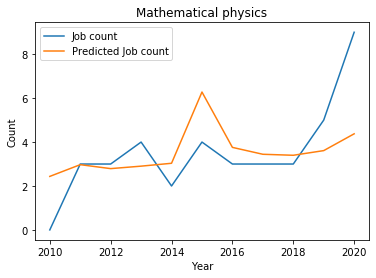

In [17]:
jobs = get_key_word_counts(r"(?i)mathematical physics", start=start, end=end)
X = metadata[metadata.categories.str.contains("math.MP")].resample("Y", on="update_date_mod").sum()[1:]
y = jobs

predicted_data = get_predictions(X,y)

plt.plot(list(range(start, end+1)),y, label='Job count')
plt.plot(list(range(start, end+1)), predicted_data[1].reshape(-1,1), label='Predicted Job count')
plt.legend(loc="upper left")
plt.ylabel('Count')
plt.xlabel('Year')
plt.title("Mathematical physics")

## Plot predictions for machine learning

Text(0.5, 1.0, 'Machine learning')

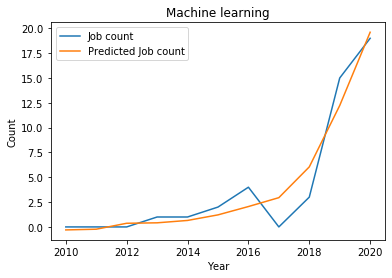

In [18]:
jobs = get_key_word_counts(r"(?i)machine learning", start=start, end=end)
X = metadata[metadata.categories.str.contains("cs.LG")].resample("Y", on="update_date_mod").sum()[1:]
y = jobs

predicted_data = get_predictions(X,y)

plt.plot(list(range(start, end+1)),y, label='Job count')
plt.plot(list(range(start, end+1)), predicted_data[1].reshape(-1,1), label='Predicted Job count')
plt.legend(loc="upper left")
plt.ylabel('Count')
plt.xlabel('Year')
plt.title("Machine learning")